# Description
The "Histopathologic Cancer Detection" Kaggle competition involves developing algorithms to identify metastatic cancer from small sections of pathology scans. The challenge focuses on detecting specific cancerous patterns within huge datasets of image patches extracted from larger images. Data provided includes a large number of high-resolution pathology scan images labeled for the presence or absence of metastatic tissue. This task requires participants to leverage machine learning techniques for accurate and efficient cancer detection, contributing to advancements in medical diagnostics.

The notebook can also be found in github under: https://github.com/MedGhassen/Histopathologic-Cancer-Detection

# Exploratory data analysis (EDA)

## Prepare DataSet

### Download the data

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'histopathologic-cancer-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F11848%2F862157%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240229%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240229T171256Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4b441c154f1dc96374317d29a3a04c5c401984b49aa977306ea75ef44077ba7bf218f738ee9c8097034e64fa5edb81a1c5409727552f7c39dd620b7349f7da2810ade037d2b6c4302a714f1264091d126b6fcd58734347796e2d1e02d37095c543162af490cbdd87f8f3d30e110b1505a6ef1c74dac6c5dee4a7890d627ec6f3a6aa34d0fabf7689a5f344a39ac7b0fc9cd7f256362e01e8bd4d119f7a45f3ad758e87b1d57751e8b686598771111e5a8ea383d2d72aaadd6b464991b9fc454ffb66cbaf944532cefb2b260d6ac44ab5f4ae3d6f8459ccbf37b22812ffdf795e01a79098a6f74a6d84421eb7df1f60d4860f1efcd727cbec9eb8d80132205182'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6773228425 bytes downloaded
Downloaded and uncompressed: histopathologic-cancer-detection
Data source import complete.


### Read Data into DataFrames

In [4]:
import pandas as pd
import os
mainFolder = '/kaggle/input/histopathologic-cancer-detection/train'
mainFolderAbsolutPath = os.path.abspath(mainFolder)
files = os.listdir(mainFolder)
filePaths = []
ids = []

for f in files:
  filePath = os.path.join(mainFolderAbsolutPath, f)
  filePaths.append(filePath)
  ids.append(os.path.splitext(os.path.basename(filePath))[0])

Fseries = pd.Series(filePaths, name= 'filePath')
Idseries = pd.Series(ids, name='id')
df = pd.concat([Fseries, Idseries], axis= 1)
df = df[df['filePath'].str.endswith('.tif')]
labels_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_df = pd.merge(df, labels_df, on='id', how='inner')
# rearrange columns
train_df = train_df[['id', 'filePath', 'label']]
train_df.dtypes

id          object
filePath    object
label        int64
dtype: object

We need to convert the type of the label to be string.

In [5]:
train_df['label'] = train_df['label'].astype(str)
train_df.dtypes

id          object
filePath    object
label       object
dtype: object

### Split into Validation and Training Data
Our model will also need data for validation, that's why we will split our data into **Training** and Validation, with 80% Training and 20% Validation data.

In [6]:
from sklearn.model_selection import train_test_split

# train dataframe
labels = train_df['label']
train_df, valid_df = train_test_split(train_df, train_size=0.8, shuffle=True, random_state=123, stratify=labels)

In [7]:
train_df

id  \
28266   0a27171938a0876b7c2faab47192f2b1ff051b8f   
170744  c3aa4ef6fe0970cb471df34221f8856b495006ff   
143418  fc955559abeb3f202dc4e2705c6cea938f67e39c   
26729   3761ec12eb4db5ee0a3d4d10b9f5dd95c0b2ff43   
197281  5c6d5bff0e876439fa8ac7d13d946c47aea28349   
...                                          ...   
154447  02a742bc1c40853f39750b30e18c32371d8272f5   
68483   029ff8337b63403ecc77d5d4516cbb5042297230   
189906  b4f8b73a1a5fbf7a94728b8ce78d9449c934936d   
161926  4947043ad31e2388a76f025cef890be6f46e8d1a   
154070  e8917e40854d8efe933c829d92ac449660d26727   

                                                 filePath label  
28266   /kaggle/input/histopathologic-cancer-detection...     1  
170744  /kaggle/input/histopathologic-cancer-detection...     1  
143418  /kaggle/input/histopathologic-cancer-detection...     0  
26729   /kaggle/input/histopathologic-cancer-detection...     1  
197281  /kaggle/input/histopathologic-cancer-detection...     0  
...                                                   ...   ...  
154447  /kaggle/input/histopathologic-cancer-detection...     0  
68483   /kaggle/input/histopathologic-cancer-detection...     0  
189906  /kaggle/input/histopathologic-cancer-detection...     0  
161926  /kaggle/input/histopathologic-cancer-detection...     0  
154070  /kaggle/input/histopathologic-cancer-detection...     0  

[176020 rows x 3 columns]

In [8]:
valid_df

id  \
120751  ec7dc5c19d27aed14ee238c8babafaf28ce2d856   
106181  b75c6dd32db9dbb5ac33e28c64988a49a748c08f   
109693  db5128af6fdf2847b6c770bba2bbe96fc3bfd118   
10835   7ca6dc24995d5bd27a56791fb776fe4385d20906   
81707   fa3bd8422a0c6a2ea26a58d290fd0a5dc9dd0571   
...                                          ...   
219816  c69c8b6d5e912895d4454ebf33539acfea559de9   
178025  2b8591a1317e7ece893e810f6b5f1574320cbe72   
41775   e191b05b9cb6f1542f2cc6861b03aed03012a898   
10658   63c883047444d953ca7c9c9ac31065d218ddd519   
45772   b268f2c620b541623818dc60a306fd54340c4787   

                                                 filePath label  
120751  /kaggle/input/histopathologic-cancer-detection...     1  
106181  /kaggle/input/histopathologic-cancer-detection...     0  
109693  /kaggle/input/histopathologic-cancer-detection...     1  
10835   /kaggle/input/histopathologic-cancer-detection...     1  
81707   /kaggle/input/histopathologic-cancer-detection...     1  
...                                                   ...   ...  
219816  /kaggle/input/histopathologic-cancer-detection...     1  
178025  /kaggle/input/histopathologic-cancer-detection...     1  
41775   /kaggle/input/histopathologic-cancer-detection...     0  
10658   /kaggle/input/histopathologic-cancer-detection...     0  
45772   /kaggle/input/histopathologic-cancer-detection...     0  

[44005 rows x 3 columns]

### Check available GPUs

In [9]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Verify if TensorFlow can see the GPU
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

# # Test GPU device name
if physical_devices:
    print("GPU Device Name:", physical_devices[0].name)


print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.15.0
Num GPUs Available:  1
GPU Device Name: /physical_device:GPU:0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Prepare Image Data Generators

We need to figure out the size of the image.

In [10]:
from PIL import Image

with Image.open(valid_df.iloc[0].filePath) as img:
    # Get image size
    width, height = img.size

print(f"The image size is {width}x{height} pixels.")

The image size is 96x96 pixels.


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size, channels, and shape
batch_size = 128
img_size = (96, 96)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create ImageDataGenerator  for training and testing
training_image_generator = ImageDataGenerator()
validation_image_generator = ImageDataGenerator()

# Training data generator
train_gen = training_image_generator.flow_from_dataframe(train_df, x_col='filePath', y_col='label',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = validation_image_generator.flow_from_dataframe(valid_df, x_col='filePath', y_col='label',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


## Plot some samples fo the data

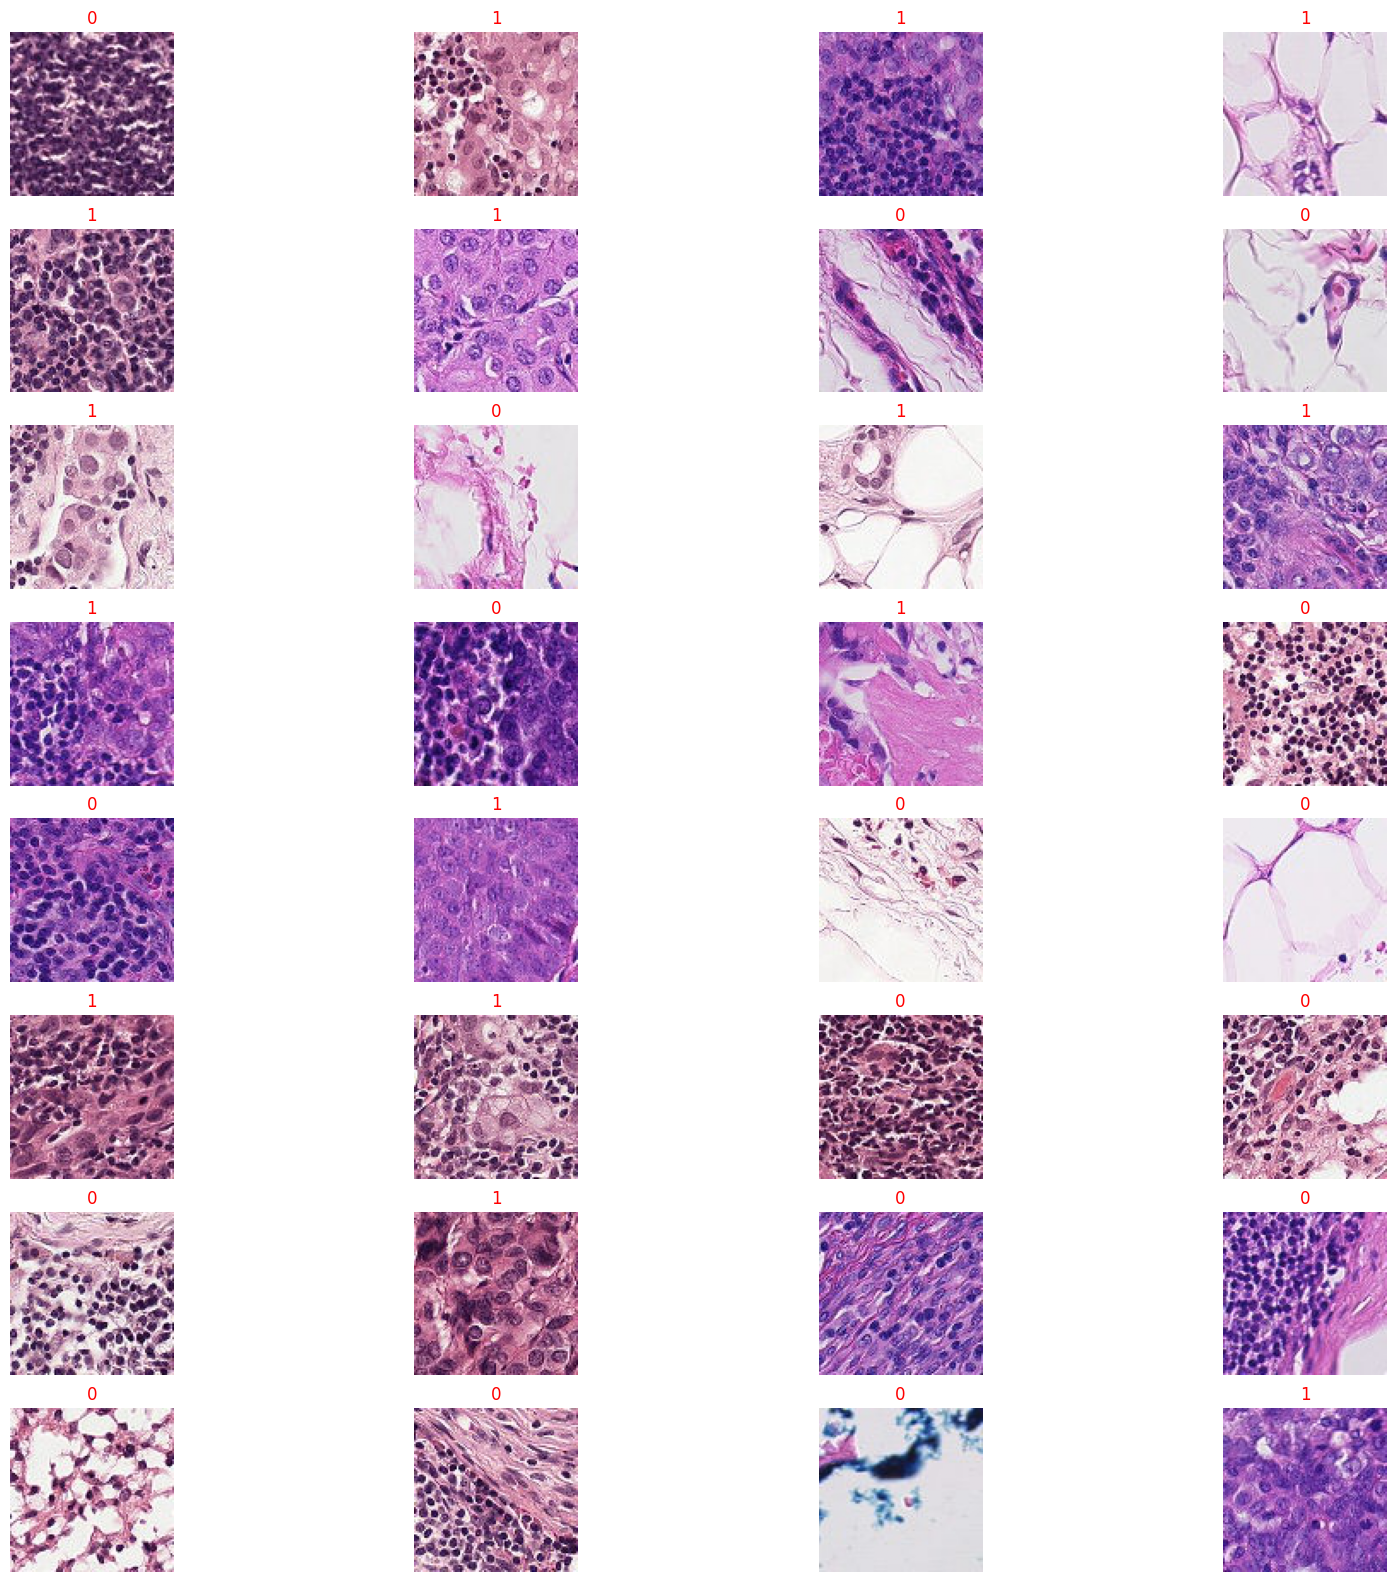

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Get the class Name from the training generator
g_dict = train_gen.class_indices

classes = list(g_dict.keys())

images, labels = next(train_gen)


plt.figure(figsize=(20, 20))

for i in range(32):

    plt.subplot(8, 4, i + 1)

    image = images[i] / 255

    plt.imshow(image)

    index = np.argmax(labels[i])

    class_name = classes[index]

    plt.title(class_name, color='red', fontsize=12)

    plt.axis('off')

plt.show()

# Define Model 'Xception'

One of the famous models for Image classification is the 'Xception' model designed by the legend Franc¸ois Chollet (Founder of Keras and Google Research Scientist). The model is published in a Paper 'Xception: Deep Learning with Depthwise Separable Convolutions'.
Reference: https://arxiv.org/pdf/1610.02357.pdf

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense

img_size = (96, 96)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

def model_Xception(input_shape, num_classes):
    # Entry flow
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Middle flow - repeat this block 8 times for full Xception
    for i in range(8):
        residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
        residual = BatchNormalization()(residual)

        x = Activation('relu')(x)
        x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
        x = tf.keras.layers.add([x, residual])

    # Exit flow
    residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.add([x, residual])

    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (96, 96, 3)
num_classes = 2
model = model_Xception(input_shape, num_classes)
model.summary()

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 47, 47, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 47, 47, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 47, 47, 32)           0         ['batch_normalization[0][0

## Train the model

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model

def get_callbacks(model_name):
    callbacks = []

    # Use correct syntax for ModelCheckpoint
    checkpoint = ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_accuracy', mode='max')
    callbacks.append(checkpoint)

    # Import ReduceLROnPlateau if not imported earlier
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
    callbacks.append(reduce_lr)

    # Import EarlyStopping if not imported earlier
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    callbacks.append(early_stopping)

    return callbacks

In [ ]:
callbacks=get_callbacks('Xception')
history_Xception=model.fit(train_gen,epochs=10,validation_data=valid_gen,callbacks=[callbacks])

Epoch 1/10
1376/1376 [==============================] - ETA: 0s - loss: 0.3515 - accuracy: 0.8471
Epoch 1: saving model to model.Xception.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1376/1376 [==============================] - 185s 121ms/step - loss: 0.3515 - accuracy: 0.8471 - val_loss: 0.7586 - val_accuracy: 0.7246 - lr: 0.0010
Epoch 2/10
1376/1376 [==============================] - ETA: 0s - loss: 0.2387 - accuracy: 0.9035
Epoch 2: saving model to model.Xception.h5
1376/1376 [==============================] - 158s 115ms/step - loss: 0.2387 - accuracy: 0.9035 - val_loss: 0.2915 - val_accuracy: 0.8811 - lr: 0.0010
Epoch 3/10
1376/1376 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.9266
Epoch 3: saving model to model.Xception.h5
1376/1376 [==============================] - 155s 113ms/step - loss: 0.1891 - accuracy: 0.9266 - val_loss: 0.5683 - val_accuracy: 0.8345 - lr: 0.0010
Epoch 4/10
1376/1376 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9399
Epoch 4: saving model to model.Xception.h5
1376/1376 [==============================] - 157s 114ms/step - loss: 0.1571 - accuracy: 0.9399 - val_loss: 0.2090 - val_accurac

## Plot of the training and validation Loss and Accuracy

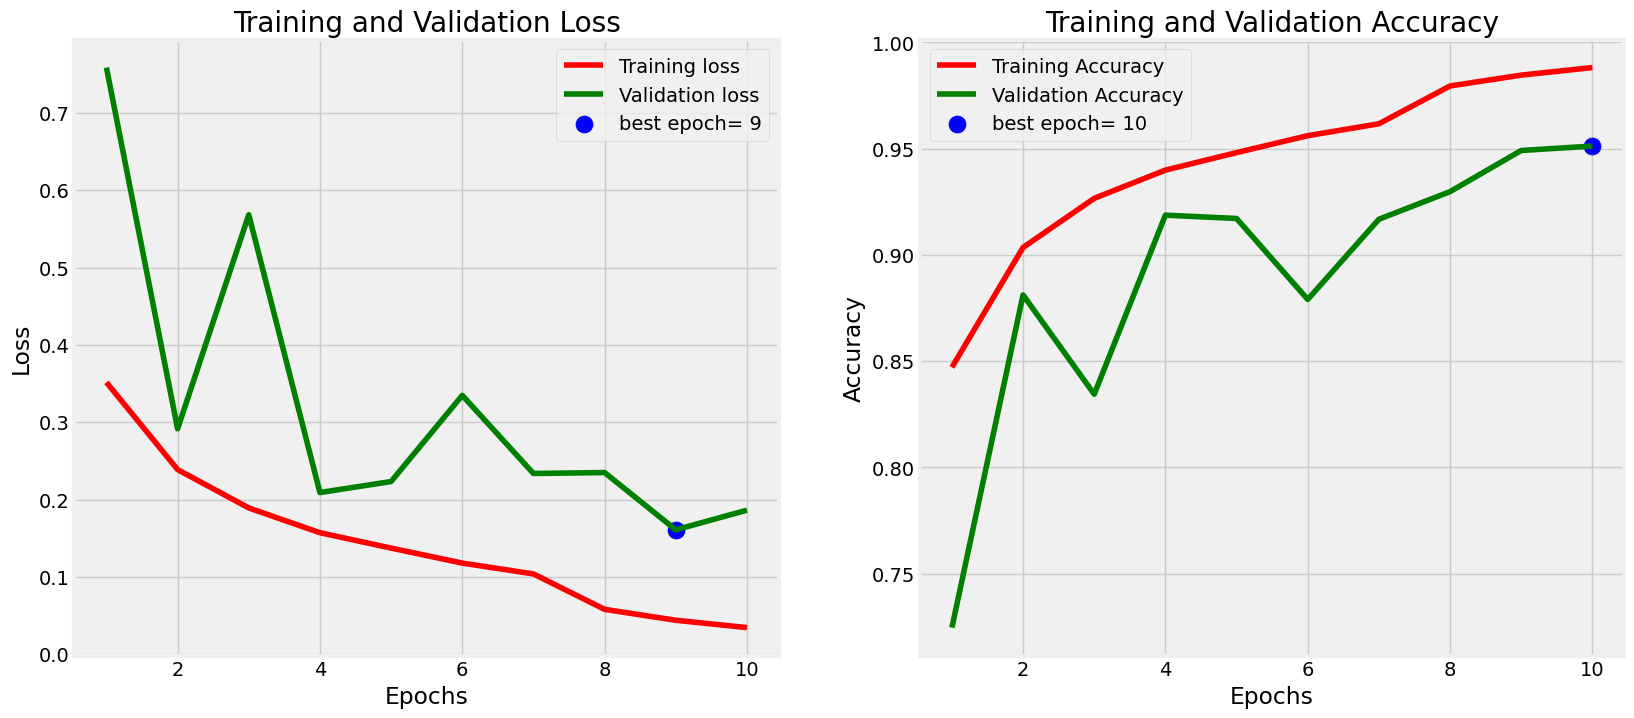

In [ ]:
def plot_loss_accuracy(history):
  tr_acc = history.history['accuracy']
  tr_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]
  Epochs = [i+1 for i in range(len(tr_acc))]
  loss_label = f'best epoch= {str(index_loss + 1)}'
  acc_label = f'best epoch= {str(index_acc + 1)}'

  plt.figure(figsize= (20, 8))
  plt.style.use('fivethirtyeight')

  plt.subplot(1, 2, 1)
  plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
  plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
  plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
  plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
  plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout
  plt.show()


plot_loss_accuracy(history_Xception)

## Prepare submission

In [19]:
import pandas as pd
import os
mainFolder = '/kaggle/input/histopathologic-cancer-detection/test'
mainFolderAbsolutPath = os.path.abspath(mainFolder)
files = os.listdir(mainFolder)
filePaths = []
ids = []

for f in files:
  filePath = os.path.join(mainFolderAbsolutPath, f)
  filePaths.append(filePath)
  ids.append(os.path.splitext(os.path.basename(filePath))[0])

Fseries = pd.Series(filePaths, name= 'filePath')
Idseries = pd.Series(ids, name='id')
test_df = pd.concat([Fseries, Idseries], axis= 1)
test_df = test_df[test_df['filePath'].str.endswith('.tif')]
test_df

filePath  \
0      /kaggle/input/histopathologic-cancer-detection...   
1      /kaggle/input/histopathologic-cancer-detection...   
2      /kaggle/input/histopathologic-cancer-detection...   
3      /kaggle/input/histopathologic-cancer-detection...   
4      /kaggle/input/histopathologic-cancer-detection...   
...                                                  ...   
57453  /kaggle/input/histopathologic-cancer-detection...   
57454  /kaggle/input/histopathologic-cancer-detection...   
57455  /kaggle/input/histopathologic-cancer-detection...   
57456  /kaggle/input/histopathologic-cancer-detection...   
57457  /kaggle/input/histopathologic-cancer-detection...   

                                             id  
0      fb605033a3b51836f9c9d9521974dc8b25f9eb05  
1      4a364c9fda95af4ca8eb7d062829c4db9706d29f  
2      45a108de5b97242e2a403f9f47cb00258da548f6  
3      48f9a618599f1e9e703b7ccfc24afbe014e7acd4  
4      91967d7eb91f199ecb75b0c877af310c3f295b9a  
...                                         ...  
57453  2dc4351c9d5a74c35a4713e8fe0d3f3105833196  
57454  d16959b3188c3d4f71c1e102fabc0891795ba29a  
57455  c761ca360a74825c2755ecf4c7096d4807824eb7  
57456  51896b1fb5a9505b00ae2d1de5127ebc9d6416d7  
57457  2e00f3b24fabf9f807765eedfb150a237bdc46e3  

[57458 rows x 2 columns]

Prepare the Test Generator

In [21]:
from tensorflow.keras.models import load_model

test_image_generator = ImageDataGenerator()
test_gen = test_image_generator.flow_from_dataframe(test_df, x_col='filePath', y_col=None,
                                                    target_size=img_size, class_mode=None,
                                                    color_mode='rgb', shuffle=False, batch_size=batch_size)

model = load_model('model.Xception.h5')

Found 57458 validated image filenames.


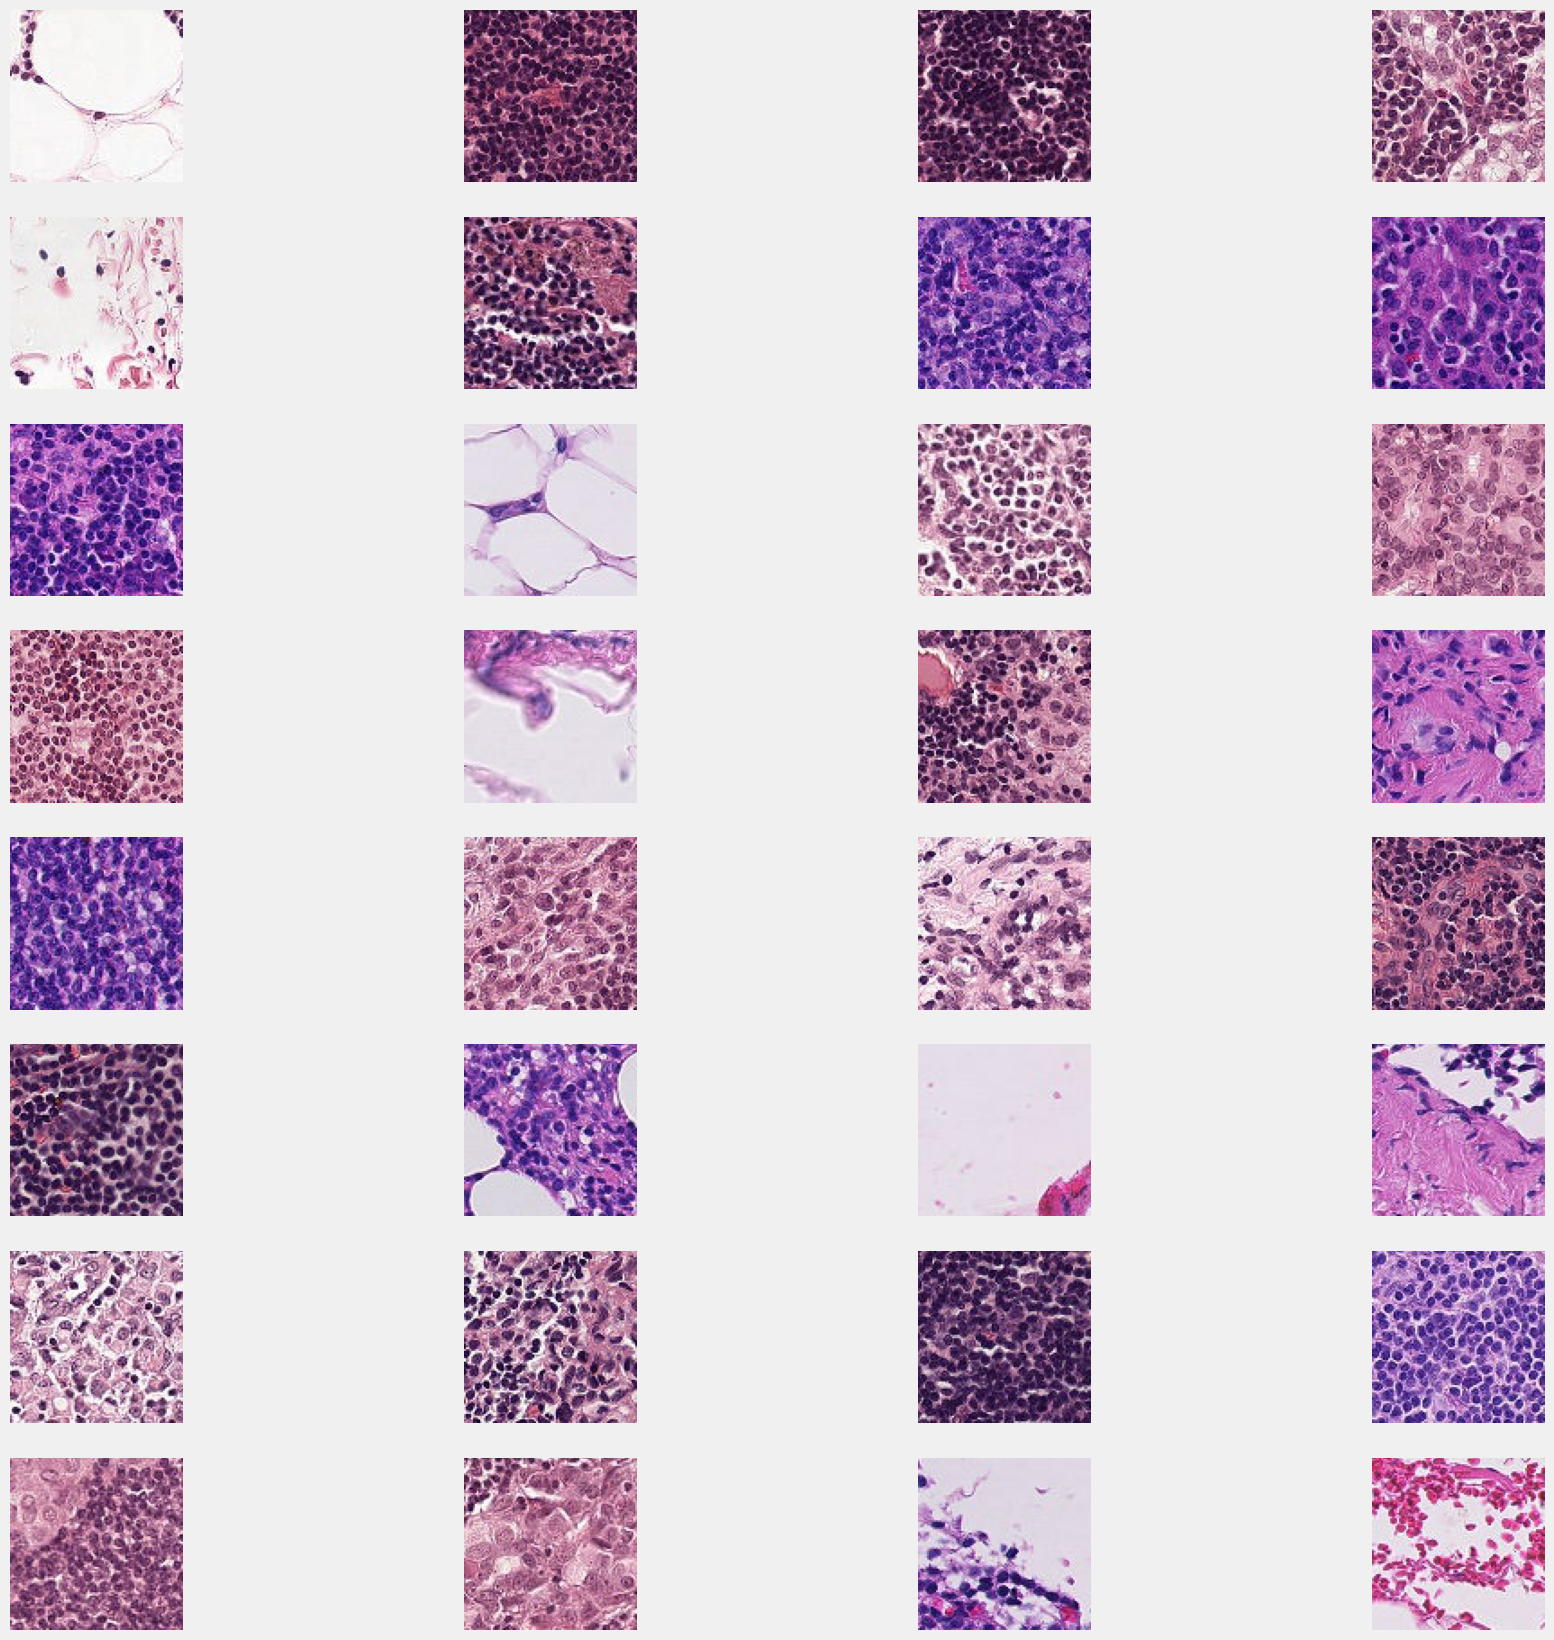

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the class Name from the training generator

images = next(test_gen)


plt.figure(figsize=(20, 20))

for i in range(32):

    plt.subplot(8, 4, i + 1)

    image = images[i] / 255

    plt.imshow(image)

    plt.axis('off')

plt.show()

In [ ]:
predictions = model.predict(test_gen, steps=np.ceil(len(test_df)/batch_size))
# Convert predictions to class indices if necessary
predicted_classes = np.argmax(predictions, axis=1)

# Map the predicted classes/labels to image IDs
results = pd.DataFrame({
    'id': test_df['id'],  # Make sure this is the correct column name for your IDs
    'label': predicted_classes
})


449/449 [==============================] - 40s 88ms/step


In [ ]:
results.describe()

label
count  57458.000000
mean       0.323088
std        0.467660
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

In [ ]:
results.to_csv('/kaggle/results.csv', index=False)

# Using the EfficientNetB0 Model

The EfficientNet model come up with the paper 'EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks'. We can take a look at it : https://arxiv.org/pdf/1905.11946.pdf

## Squeeze-and-Excitation (SE) Block
The SE block re-calibrates channel-wise feature responses by explicitly modelling interdependencies between channels.


In [ ]:
from tensorflow.keras import layers, models

def SEBlock(input_filters, ratio=4):
    def block(inputs):
        se_shape = (1, 1, input_filters)
        se = layers.GlobalAveragePooling2D()(inputs)
        se = layers.Reshape(se_shape)(se)
        se = layers.Dense(input_filters // ratio, activation='relu')(se)
        se = layers.Dense(input_filters, activation='sigmoid')(se)
        return layers.multiply([inputs, se])
    return block

## MBConv Block
The MBConv block is an inverted residual block that uses depthwise separable convolutions. This block is the core building block of EfficientNet.

In [ ]:
def MBConvBlock(input_filters, output_filters, kernel_size, strides, expand_ratio, se_ratio, drop_rate=0.2):
    def block(inputs):
        # Expansion phase (Inverted Residual)
        filters = input_filters * expand_ratio
        if expand_ratio != 1:
            x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(inputs)
            x = layers.BatchNormalization()(x)
            x = layers.ReLU()(x)
        else:
            x = inputs

        # Depthwise convolution phase
        x = layers.DepthwiseConv2D(kernel_size, strides=strides, depth_multiplier=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        # Squeeze and Excitation phase
        if se_ratio:
            x = SEBlock(filters, se_ratio)(x)

        # Output phase
        x = layers.Conv2D(output_filters, 1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)

        if strides == 1 and input_filters == output_filters:
            if drop_rate > 0:
                x = layers.Dropout(drop_rate)(x)
            x = layers.add([x, inputs])
        return x
    return block


## EfficientNetB0 Architecture
Here we define the overall architecture of EfficientNetB0, integrating the components we defined above.

In [ ]:
def EfficientNetB0(input_shape=(96, 96, 3), dropout_rate=0.2, num_classes=2):
    inputs = layers.Input(shape=input_shape)

    # Stem
    x = layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # MBConv blocks with parameters: input_filters, output_filters, kernel_size, strides, expand_ratio, se_ratio
    x = MBConvBlock(32, 16, 3, 1, 1, 0.25)(x)

    x = MBConvBlock(16, 24, 3, 2, 6, 0.25)(x)
    x = MBConvBlock(24, 24, 3, 1, 6, 0.25)(x)

    x = MBConvBlock(24, 40, 5, 2, 6, 0.25)(x)
    x = MBConvBlock(40, 40, 5, 1, 6, 0.25)(x)

    # More MBConv blocks would follow here, but are omitted for brevity

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Instantiate the model
model = EfficientNetB0()
print(model.summary())

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


## Train the Model

In [ ]:
callbacks=get_callbacks('EfficientNetB0')
history_EfficientNetB0=model.fit(train_gen,epochs=10,validation_data=valid_gen,callbacks=[callbacks])

Epoch 1/10
1376/1376 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.8608
Epoch 1: saving model to model.EfficientNetB0.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1376/1376 [==============================] - 169s 115ms/step - loss: 0.3250 - accuracy: 0.8608 - val_loss: 0.3159 - val_accuracy: 0.8740 - lr: 0.0010
Epoch 2/10
1376/1376 [==============================] - ETA: 0s - loss: 0.2430 - accuracy: 0.9016
Epoch 2: saving model to model.EfficientNetB0.h5
1376/1376 [==============================] - 158s 115ms/step - loss: 0.2430 - accuracy: 0.9016 - val_loss: 0.3263 - val_accuracy: 0.8706 - lr: 0.0010
Epoch 3/10
1376/1376 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.9166
Epoch 3: saving model to model.EfficientNetB0.h5
1376/1376 [==============================] - 155s 113ms/step - loss: 0.2110 - accuracy: 0.9166 - val_loss: 0.2169 - val_accuracy: 0.9138 - lr: 0.0010
Epoch 4/10
1376/1376 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.9264
Epoch 4: saving model to model.EfficientNetB0.h5
1376/1376 [==============================] - 159s 115ms/step - loss: 0.1883 - accuracy: 0.9264 - val_loss: 0.

## Plot the training and Validation Loss and Accuracy

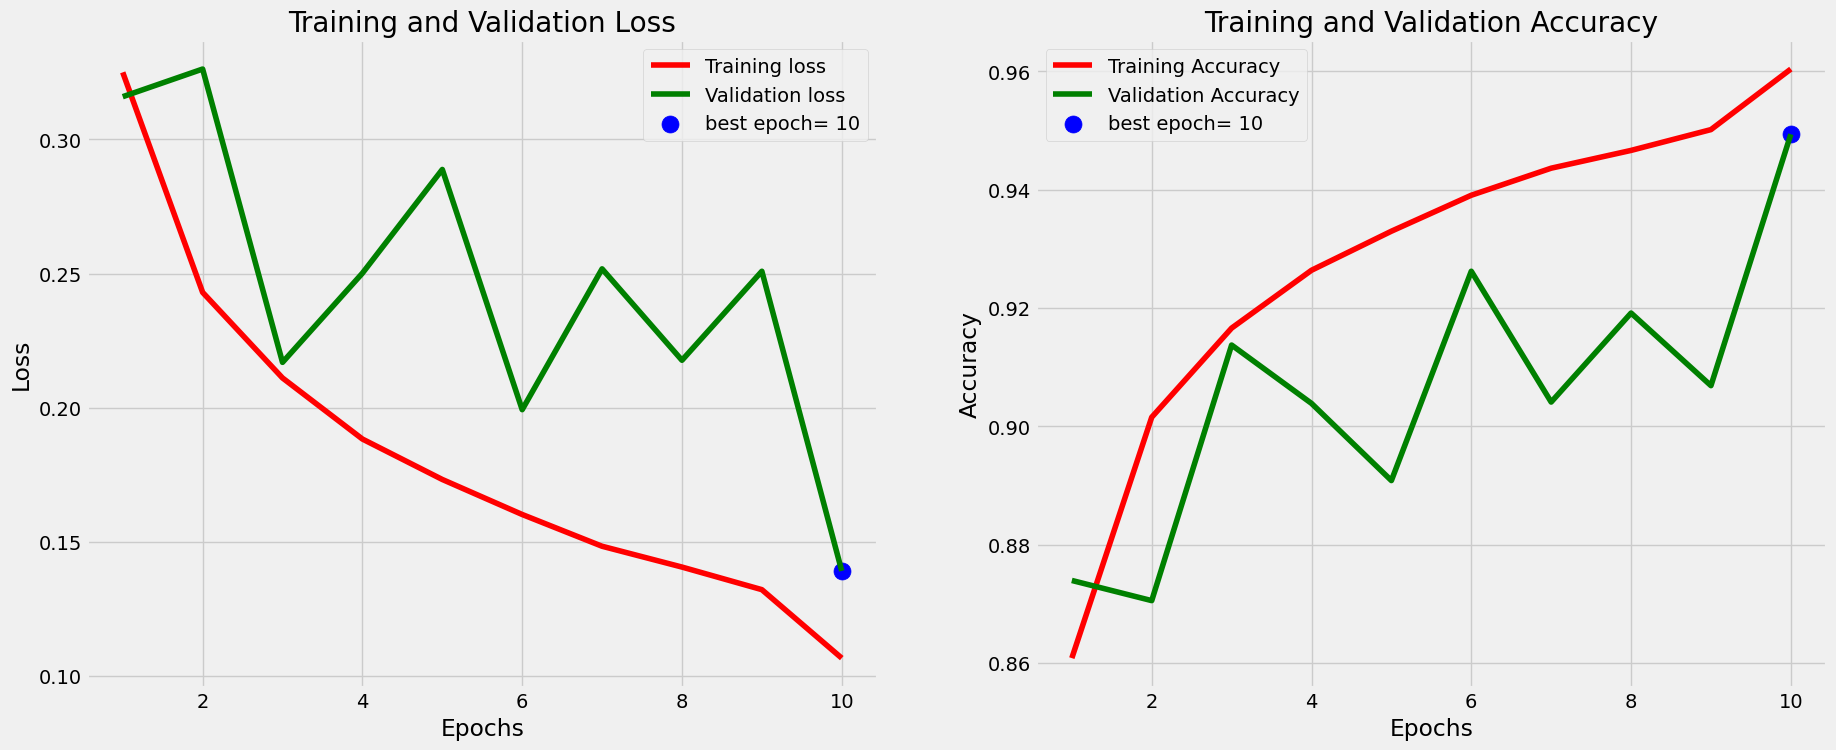

In [ ]:
plot_loss_accuracy(history_EfficientNetB0)

In [ ]:
model = load_model('model.EfficientNetB0.h5')

In [ ]:
predictions = model.predict(test_gen, steps=np.ceil(len(test_df)/batch_size))
# Convert predictions to class indices if necessary
predicted_classes = np.argmax(predictions, axis=1)

# Map the predicted classes/labels to image IDs
results = pd.DataFrame({
    'id': test_df['id'],  # Make sure this is the correct column name for your IDs
    'label': predicted_classes
})


449/449 [==============================] - 40s 89ms/step


In [ ]:
results.to_csv('/kaggle/results_EfficientNetB0.csv', index=False)

# Using a pre-trained EfficientNetB7 Model

## Import and Adapt the model

We need to import the model and adapt the input shape to match our images shape and adapt the output layer to match our number of classess (two in this case).

In [ ]:
from tensorflow.keras.applications import EfficientNetB7

# Load the pre-trained EfficientNetB7 model
base_model = EfficientNetB7(include_top=False, weights='imagenet', input_shape=(96, 96, 3))

model.trainable = True
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(2, activation='softmax')(x)  # Use softmax for multi-class classification

model = Model(inputs=base_model.input, outputs=output)
model.summary()


258076736/258076736 [==============================] - 9s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 96, 96, 3)            0         ['input_6[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 96, 96, 3)            7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling) 

## Train the EfficientNetB7 Model

In [ ]:
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callbacks=get_callbacks('EfficientNetB7')
history_EfficientNetB7=model.fit(train_gen,epochs=20,validation_data=valid_gen,callbacks=[callbacks])

Epoch 1/20


KeyboardInterrupt: 

## Plot the training and Validation Loss and Accuracy

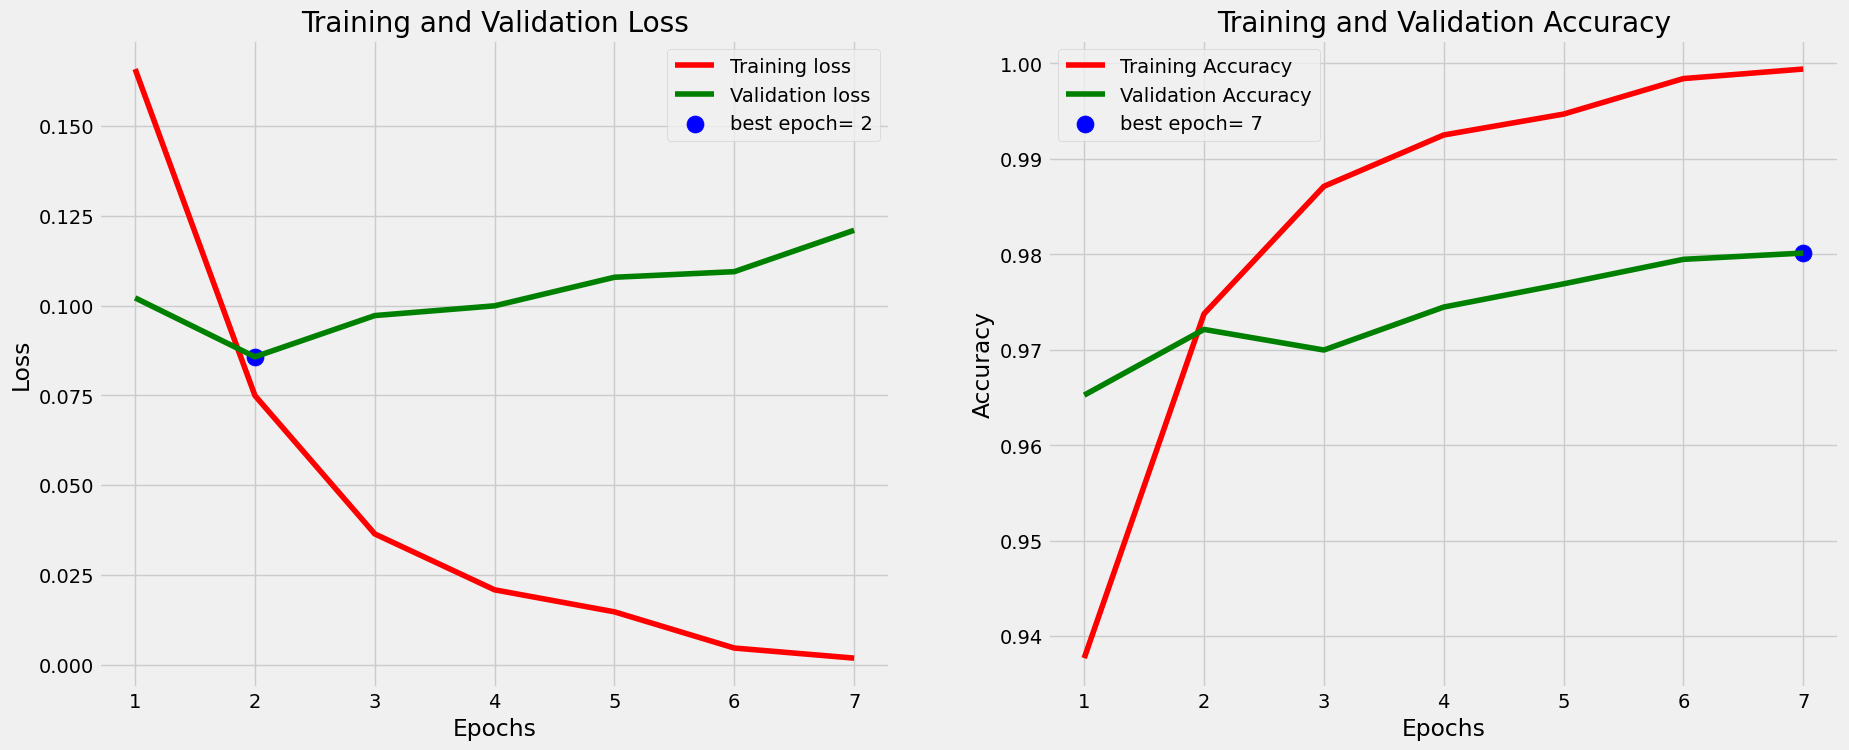

In [ ]:
plot_loss_accuracy(history_EfficientNetB7)

In [ ]:
model = load_model('model.EfficientNetB7.h5')
predictions = model.predict(test_gen, steps=np.ceil(len(test_df)/batch_size))
# Convert predictions to class indices if necessary
predicted_classes = np.argmax(predictions, axis=1)

# Map the predicted classes/labels to image IDs
results = pd.DataFrame({
    'id': test_df['id'],  # Make sure this is the correct column name for your IDs
    'label': predicted_classes
})
results.to_csv('/kaggle/results_EfficientNetB7.csv', index=False)

449/449 [==============================] - 59s 119ms/step


# Using a pre-trained Xception Model


## Define and Adapt the model

In [ ]:
from tensorflow.keras.applications import Xception

base_model = Xception(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 47, 47, 32)           864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 47, 47, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 47, 47, 32)           0         ['block1_conv1_bn[0][0]'

## Train the model



In [ ]:
callbacks=get_callbacks('xception_trained')
history_xception_trained=model.fit(train_gen,epochs=20,validation_data=valid_gen,callbacks=[callbacks])

Epoch 1/20
1376/1376 [==============================] - ETA: 0s - loss: 0.1782 - accuracy: 0.9330
Epoch 1: saving model to model.xception_trained.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1376/1376 [==============================] - 210s 137ms/step - loss: 0.1782 - accuracy: 0.9330 - val_loss: 0.1873 - val_accuracy: 0.9301 - lr: 0.0010
Epoch 2/20
1376/1376 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.9618
Epoch 2: saving model to model.xception_trained.h5
1376/1376 [==============================] - 189s 138ms/step - loss: 0.1083 - accuracy: 0.9618 - val_loss: 0.3626 - val_accuracy: 0.9016 - lr: 0.0010
Epoch 3/20
1376/1376 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9716
Epoch 3: saving model to model.xception_trained.h5
1376/1376 [==============================] - 189s 137ms/step - loss: 0.0820 - accuracy: 0.9716 - val_loss: 0.1428 - val_accuracy: 0.9541 - lr: 0.0010
Epoch 4/20
1376/1376 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9786
Epoch 4: saving model to model.xception_trained.h5
1376/1376 [==============================] - 190s 138ms/step - loss: 0.0612 - accuracy: 0.9786 - val_lo

## Plot the training and Validation Loss and Accuracy

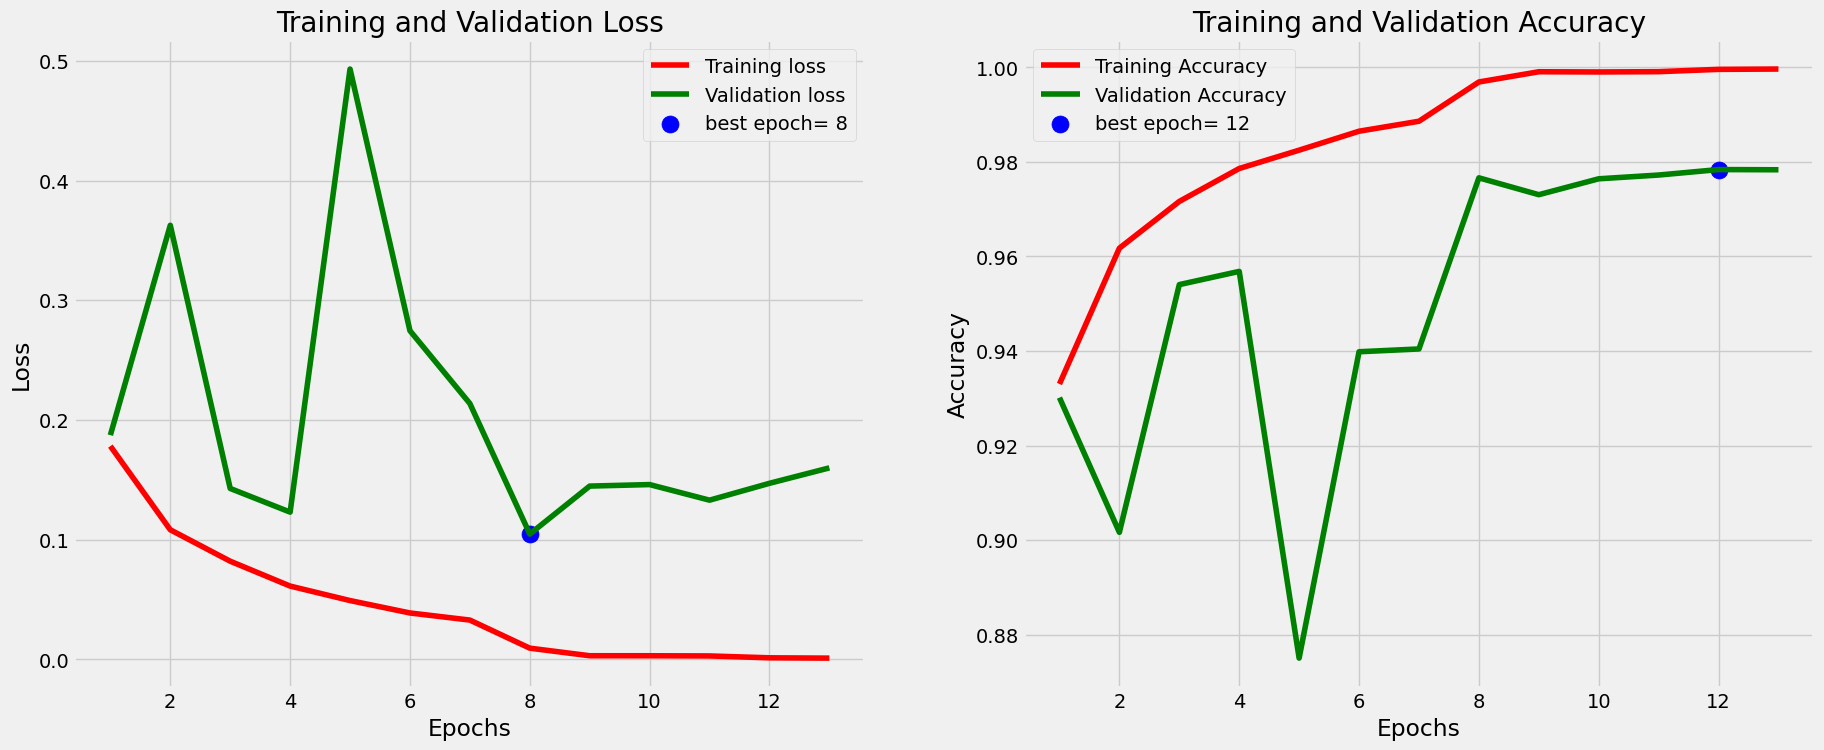

In [ ]:
plot_loss_accuracy(history_xception_trained)

In [ ]:
model = load_model('model.xception_trained.h5')
predictions = model.predict(test_gen, steps=np.ceil(len(test_df)/batch_size))
# Convert predictions to class indices if necessary
predicted_classes = np.argmax(predictions, axis=1)

# Map the predicted classes/labels to image IDs
results = pd.DataFrame({
    'id': test_df['id'],  # Make sure this is the correct column name for your IDs
    'label': predicted_classes
})
results.to_csv('/kaggle/results_xception_trained.csv', index=False)

449/449 [==============================] - 41s 89ms/step


# Using a pre-trained DenseNet121 Model


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import load_model

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 zero_padding2d_6 (ZeroPadd  (None, 102, 102, 3)          0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 48, 48, 64)           9408      ['zero_padding2d_6[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 48, 48, 64)           256       ['conv1/conv[0][0]']    

## Train the model


In [ ]:
callbacks=get_callbacks('DenseNet121_trained')
history_DenseNet121_trained=model.fit(train_gen,epochs=20,validation_data=valid_gen,callbacks=[callbacks])

Epoch 1/20
1376/1376 [==============================] - ETA: 0s - loss: 6.7484e-04 - accuracy: 0.9998
Epoch 1: saving model to model.DenseNet121_trained.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1376/1376 [==============================] - 219s 130ms/step - loss: 6.7484e-04 - accuracy: 0.9998 - val_loss: 0.1850 - val_accuracy: 0.9755 - lr: 8.0000e-06
Epoch 2/20
1376/1376 [==============================] - ETA: 0s - loss: 7.0127e-04 - accuracy: 0.9997
Epoch 2: saving model to model.DenseNet121_trained.h5
1376/1376 [==============================] - 178s 129ms/step - loss: 7.0127e-04 - accuracy: 0.9997 - val_loss: 0.1868 - val_accuracy: 0.9756 - lr: 8.0000e-06
Epoch 3/20
1376/1376 [==============================] - ETA: 0s - loss: 5.7897e-04 - accuracy: 0.9998
Epoch 3: saving model to model.DenseNet121_trained.h5
1376/1376 [==============================] - 178s 129ms/step - loss: 5.7897e-04 - accuracy: 0.9998 - val_loss: 0.1886 - val_accuracy: 0.9759 - lr: 8.0000e-06
Epoch 4/20
1376/1376 [==============================] - ETA: 0s - loss: 6.9479e-04 - accuracy: 0.9998
Epoch 4: saving model to model.DenseNet121_trained.h5

Epoch 4: ReduceLROnPlateau reducing learning rate to 1.60

## Plot the training and validation Loss and Accuracy

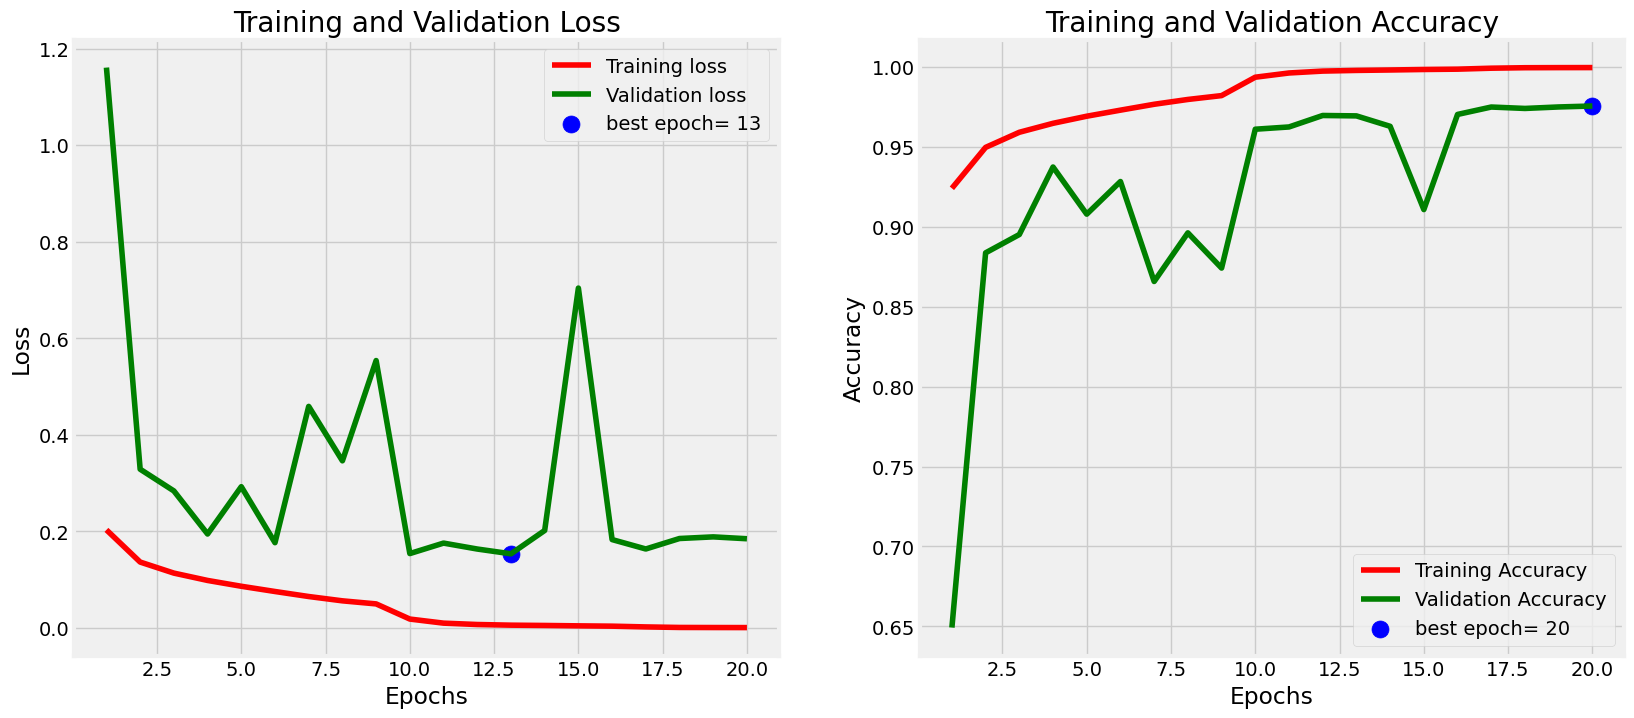

In [ ]:
plot_loss_accuracy(history_DenseNet121_trained)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.DenseNet121_trained.h5')
predictions = model.predict(test_gen, steps=np.ceil(len(test_df)/batch_size))
# Convert predictions to class indices if necessary
predicted_classes = np.argmax(predictions, axis=1)

# Map the predicted classes/labels to image IDs
results = pd.DataFrame({
    'id': test_df['id'],  # Make sure this is the correct column name for your IDs
    'label': predicted_classes
})
results.to_csv('/kaggle/results_DenseNet121_trained_new.csv', index=False)

449/449 [==============================] - 40s 85ms/step


# Use Xception pre-trained model with binary classificaiton

## Prepare the model

In [1]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load the base Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = True  # Set to True if you want to fine-tune the base model

# Add new layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
x = Dense(1024, activation='relu')(x)  # Add a fully-connected layer
predictions = Dense(1, activation='sigmoid')(x)  # Change to 1 unit with sigmoid for binary classification

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Use binary_crossentropy for binary classification
model.summary()


83683744/83683744 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 47, 47, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 47, 47, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size, channels, and shape
batch_size = 128
img_size = (96, 96)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create ImageDataGenerator  for training and testing
training_image_generator = ImageDataGenerator()
validation_image_generator = ImageDataGenerator()

# Training data generator
train_gen = training_image_generator.flow_from_dataframe(train_df, x_col='filePath', y_col='label',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = validation_image_generator.flow_from_dataframe(valid_df, x_col='filePath', y_col='label',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

## Prepare Data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size, channels, and shape
batch_size = 128
img_size = (96, 96)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create ImageDataGenerator for training and validation
training_image_generator = ImageDataGenerator()
validation_image_generator = ImageDataGenerator()

# Training data generator
train_gen = training_image_generator.flow_from_dataframe(
    train_df,
    x_col='filePath',
    y_col='label',
    target_size=img_size,
    class_mode='binary',  # Change to 'binary'
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Validation data generator
valid_gen = validation_image_generator.flow_from_dataframe(
    valid_df,
    x_col='filePath',
    y_col='label',
    target_size=img_size,
    class_mode='binary',  # Change to 'binary'
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


## Train the model

In [ ]:
callbacks=get_callbacks('Xception_trained_binary')
history_Xception_trained_binary=model.fit(train_gen,epochs=10,validation_data=valid_gen,callbacks=[callbacks])

Epoch 1/10
1376/1376 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.9329
Epoch 1: saving model to model.Xception_trained_binary.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1376/1376 [==============================] - 221s 139ms/step - loss: 0.1786 - accuracy: 0.9329 - val_loss: 0.2251 - val_accuracy: 0.9228 - lr: 0.0010
Epoch 2/10
1376/1376 [==============================] - ETA: 0s - loss: 0.1088 - accuracy: 0.9614
Epoch 2: saving model to model.Xception_trained_binary.h5
1376/1376 [==============================] - 188s 137ms/step - loss: 0.1088 - accuracy: 0.9614 - val_loss: 0.2312 - val_accuracy: 0.9212 - lr: 0.0010
Epoch 3/10
1376/1376 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.9709
Epoch 3: saving model to model.Xception_trained_binary.h5
1376/1376 [==============================] - 189s 137ms/step - loss: 0.0831 - accuracy: 0.9709 - val_loss: 0.1317 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 4/10
1376/1376 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9746
Epoch 4: saving model to model.Xception_trained_binary.h5
1376/1376 [==============================] - 188s 137ms/step - loss: 0.0723 - accu

## Plot the training and validation Loss and accuracy

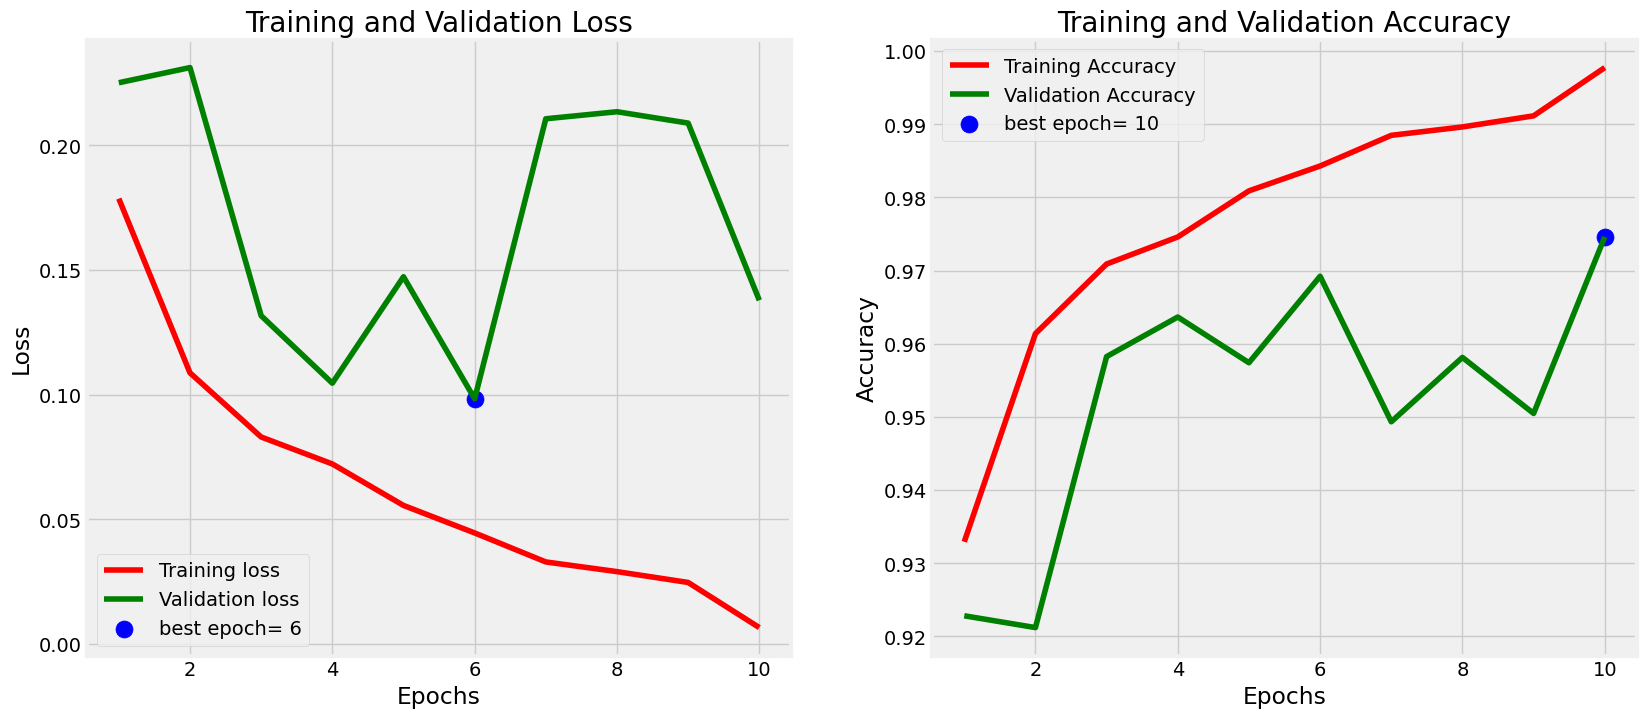

In [ ]:
plot_loss_accuracy(history_Xception_trained_binary)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.Xception_trained_binary.h5')
predictions = model.predict(test_gen, steps=np.ceil(len(test_df)/batch_size))
# Convert predictions to class indices if necessary
predicted_classes = (predictions > 0.5).astype(int)
num_positive_predictions = np.sum(predicted_classes.flatten())


449/449 [==============================] - 39s 85ms/step


In [ ]:
num_positive_predictions

16474

In [ ]:
# Map the predicted classes/labels to image IDs
results = pd.DataFrame({
    'id': test_df['id'],  # Make sure this is the correct column name for your IDs
    'label': predicted_classes.flatten()
})
results.to_csv('/kaggle/Xception_trained_binary.csv', index=False)

# Fine Tune Xception model

## Define Model

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Assuming 'train_gen' is your training data generator
class_count = len(list(train_gen.class_indices.keys()))

def model_Xception(input_shape, num_classes):
    # Entry flow
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Middle flow - repeat this block 8 times for full Xception
    for i in range(8):
        residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
        residual = BatchNormalization()(residual)

        x = Activation('relu')(x)
        x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
        x = Dropout(0.2)(x)  # Add dropout
        x = tf.keras.layers.add([x, residual])

    # Exit flow
    residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Dropout(0.3)(x)  # Increase dropout
    x = tf.keras.layers.add([x, residual])

    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Add dropout before the final layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (96, 96, 3)
num_classes = class_count  # Update this according to your dataset
model = model_Xception(input_shape, num_classes)

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 47, 47, 32)           864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_8 (Bat  (None, 47, 47, 32)           128       ['conv2d_8[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 47, 47, 32)           0         ['batch_normalization_8[

## Train the model

In [15]:
callbacks=get_callbacks('Xception_with_droptout')
history_Xception_with_droptout=model.fit(train_gen,epochs=20,validation_data=valid_gen,callbacks=[callbacks])

Epoch 1/20
1376/1376 [==============================] - ETA: 0s - loss: 0.3703 - accuracy: 0.8394
Epoch 1: saving model to model.Xception_with_droptout.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1376/1376 [==============================] - 180s 118ms/step - loss: 0.3703 - accuracy: 0.8394 - val_loss: 0.4759 - val_accuracy: 0.8015 - lr: 0.0010
Epoch 2/20
1376/1376 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.8950
Epoch 2: saving model to model.Xception_with_droptout.h5
1376/1376 [==============================] - 151s 110ms/step - loss: 0.2596 - accuracy: 0.8950 - val_loss: 0.2753 - val_accuracy: 0.8901 - lr: 0.0010
Epoch 3/20
1376/1376 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.9145
Epoch 3: saving model to model.Xception_with_droptout.h5
1376/1376 [==============================] - 148s 107ms/step - loss: 0.2166 - accuracy: 0.9145 - val_loss: 0.2118 - val_accuracy: 0.9176 - lr: 0.0010
Epoch 4/20
1376/1376 [==============================] - ETA: 0s - loss: 0.1886 - accuracy: 0.9275
Epoch 4: saving model to model.Xception_with_droptout.h5
1376/1376 [==============================] - 145s 106ms/step - loss: 0.1886 - accurac

## Plot the training and validation loss and accuracy

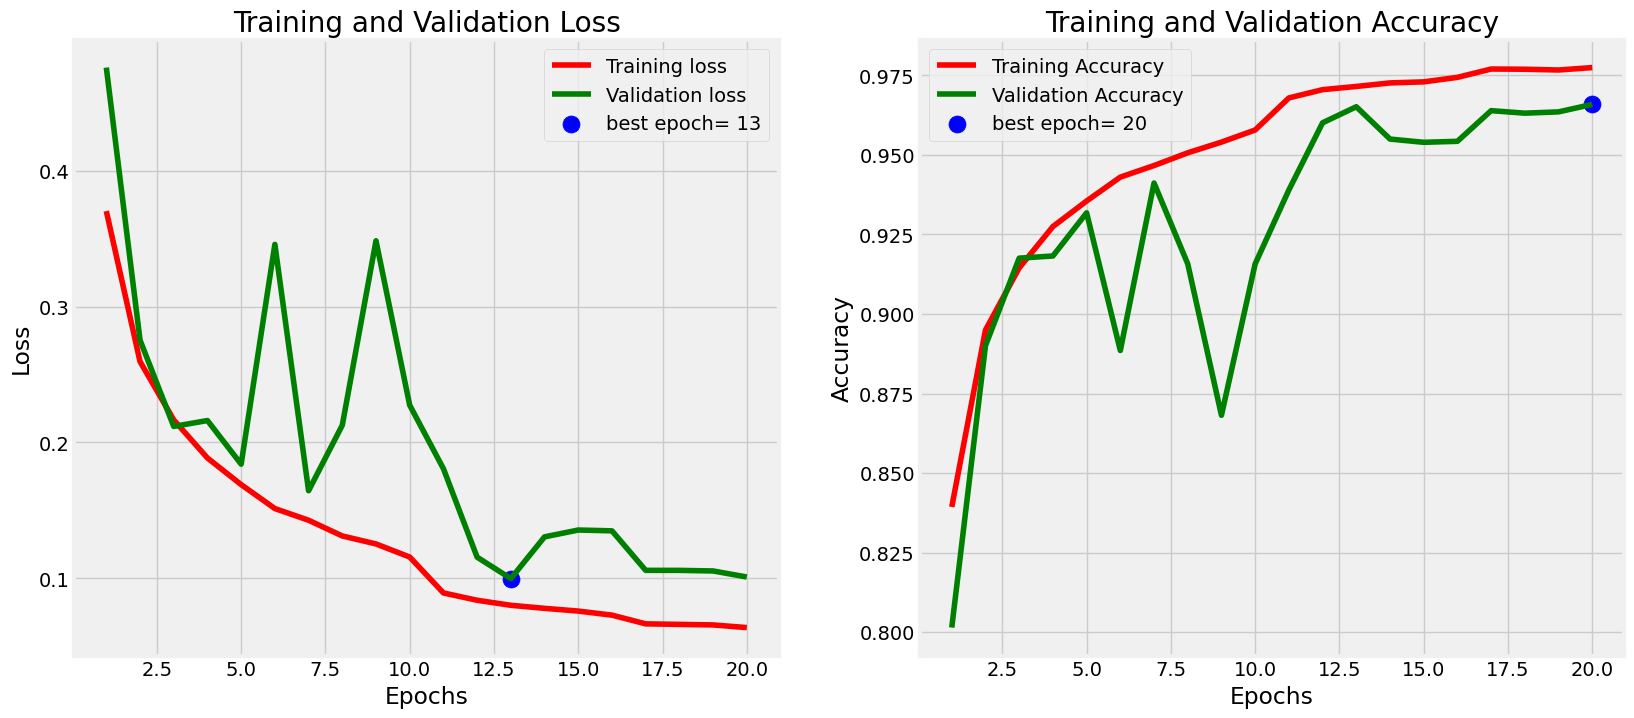

In [16]:
plot_loss_accuracy(history_Xception_with_droptout)

In [22]:
from tensorflow.keras.models import load_model

model = load_model('model.Xception_with_droptout.h5')
predictions = model.predict(test_gen, steps=np.ceil(len(test_df)/batch_size))
# Convert predictions to class indices if necessary
predicted_classes = np.argmax(predictions, axis=1)

# Map the predicted classes/labels to image IDs
results = pd.DataFrame({
    'id': test_df['id'],  # Make sure this is the correct column name for your IDs
    'label': predicted_classes
})
results.to_csv('/kaggle/Xception_with_droptout.csv', index=False)

449/449 [==============================] - 39s 86ms/step


In [23]:
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callbacks=get_callbacks('Xception_with_droptout')
history_Xception_with_droptout=model.fit(train_gen,epochs=20,validation_data=valid_gen,callbacks=[callbacks])

Epoch 1/20
1376/1376 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9629
Epoch 1: saving model to model.Xception_with_droptout.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1376/1376 [==============================] - 154s 103ms/step - loss: 0.1005 - accuracy: 0.9629 - val_loss: 0.4018 - val_accuracy: 0.8568 - lr: 0.0010
Epoch 2/20
1376/1376 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.9657
Epoch 2: saving model to model.Xception_with_droptout.h5
1376/1376 [==============================] - 140s 101ms/step - loss: 0.0943 - accuracy: 0.9657 - val_loss: 0.2683 - val_accuracy: 0.9206 - lr: 0.0010
Epoch 3/20
1376/1376 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.9672
Epoch 3: saving model to model.Xception_with_droptout.h5
1376/1376 [==============================] - 142s 104ms/step - loss: 0.0902 - accuracy: 0.9672 - val_loss: 0.1340 - val_accuracy: 0.9532 - lr: 0.0010
Epoch 4/20
1376/1376 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9689
Epoch 4: saving model to model.Xception_with_droptout.h5
1376/1376 [==============================] - 140s 102ms/step - loss: 0.0859 - accurac

In [25]:
model = load_model('model.Xception_with_droptout.h5')
predictions = model.predict(test_gen, steps=np.ceil(len(test_df)/batch_size))
# Convert predictions to class indices if necessary
predicted_classes = np.argmax(predictions, axis=1)

# Map the predicted classes/labels to image IDs
results = pd.DataFrame({
    'id': test_df['id'],  # Make sure this is the correct column name for your IDs
    'label': predicted_classes
})
results.to_csv('/kaggle/Xception_with_droptout.csv', index=False)

449/449 [==============================] - 36s 80ms/step


Training more does not help the convergence and also drop the score in the Kaggle competition.
We will try to apply regularizations and some improvements to the dropouts.

In [34]:
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def model_Xception(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), use_bias=False, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Middle flow
    for i in range(12):  # Repeat this block 12 times
        residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
        residual = BatchNormalization()(residual)

        x = Activation('relu')(x)
        x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
        x = Dropout(0.2)(x)  # Dropout to prevent overfitting
        x = tf.keras.layers.add([x, residual])

    # Exit flow
    residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Dropout(0.3)(x)  # Increased dropout
    x = tf.keras.layers.add([x, residual])

    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Further dropout before the final layer
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)

    model = Model(inputs, outputs)
    return model

input_shape = (96, 96, 3)
num_classes = class_count
model = model_Xception(input_shape, num_classes)

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d_67 (Conv2D)          (None, 47, 47, 32)           864       ['input_8[0][0]']             
                                                                                                  
 batch_normalization_170 (B  (None, 47, 47, 32)           128       ['conv2d_67[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 activation_113 (Activation  (None, 47, 47, 32)           0         ['batch_normalization_17

In [35]:
callbacks=get_callbacks('Xception_with_droptout_and_regularizations')
history_Xception_with_droptout_and_regularizations=model.fit(train_gen,epochs=20,validation_data=valid_gen,callbacks=[callbacks])

Epoch 1/20
1376/1376 [==============================] - ETA: 0s - loss: 16.2512 - accuracy: 0.8108
Epoch 1: saving model to model.Xception_with_droptout_and_regularizations.h5
1376/1376 [==============================] - 167s 108ms/step - loss: 16.2512 - accuracy: 0.8108 - val_loss: 1.0505 - val_accuracy: 0.8176 - lr: 0.0010
Epoch 2/20
1376/1376 [==============================] - ETA: 0s - loss: 0.9037 - accuracy: 0.8458
Epoch 2: saving model to model.Xception_with_droptout_and_regularizations.h5
1376/1376 [==============================] - 148s 107ms/step - loss: 0.9037 - accuracy: 0.8458 - val_loss: 0.9839 - val_accuracy: 0.8015 - lr: 0.0010
Epoch 3/20
1376/1376 [==============================] - ETA: 0s - loss: 0.7716 - accuracy: 0.8657
Epoch 3: saving model to model.Xception_with_droptout_and_regularizations.h5
1376/1376 [==============================] - 140s 101ms/step - loss: 0.7716 - accuracy: 0.8657 - val_loss: 1.6966 - val_accuracy: 0.5950 - lr: 0.0010
Epoch 4/20
1376/1376 [=

KeyboardInterrupt: 

In [32]:
model = load_model('model.Xception_with_droptout_and_regularizations.h5')
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
predictions = model.predict(test_gen, steps=np.ceil(len(test_df)/batch_size))
# Convert predictions to class indices if necessary
predicted_classes = np.argmax(predictions, axis=1)

# Map the predicted classes/labels to image IDs
results = pd.DataFrame({
    'id': test_df['id'],  # Make sure this is the correct column name for your IDs
    'label': predicted_classes
})
results.to_csv('/kaggle/Xception_with_droptout_and_regularizations.csv', index=False)

449/449 [==============================] - 40s 87ms/step


# Use Ensemble Model

We have seen so far that our best performing models are:
- EfficientNetB7 : 0.8797
- Xception : 0.8763

We will try and build an Ensemble model that uses both models.

## Prepare model

In [38]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Concatenate

img_size = (96, 96)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

def model_Xception(input_shape, num_classes):
    # Entry flow
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Middle flow - repeat this block 8 times for full Xception
    for i in range(8):
        residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
        residual = BatchNormalization()(residual)

        x = Activation('relu')(x)
        x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
        x = tf.keras.layers.add([x, residual])

    # Exit flow
    residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.add([x, residual])

    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

def create_efficientnet_model(input_shape, num_classes):
    base_model = EfficientNetB7(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True
    inputs = base_model.input
    x = GlobalAveragePooling2D()(base_model.output)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

def create_ensemble_model(models, input_shape, num_classes):
    inputs = Input(shape=input_shape)
    outputs = [model(inputs) for model in models]  # Get outputs from both models
    merge = Concatenate()(outputs)  # Combine the outputs
    merge = Dropout(0.5)(merge)  # Add some dropout for regularization
    final_output = Dense(num_classes, activation='softmax')(merge)
    ensemble_model = Model(inputs, final_output)
    return ensemble_model

input_shape = (96, 96, 3)
num_classes = 2
xception_model = model_Xception(input_shape, num_classes)
efficientnet_model = create_efficientnet_model(input_shape, num_classes)
model = create_ensemble_model([xception_model, efficientnet_model], input_shape, num_classes)

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 model_11 (Functional)       (None, 2)                    757298    ['input_15[0][0]']            
                                                                                                  
 model_12 (Functional)       (None, 2)                    6410280   ['input_15[0][0]']            
                                                          9                                       
                                                                                                  
 concatenate (Concatenate)   (None, 4)                    0         ['model_11[0][0]',     

## Train the model

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size, channels, and shape
batch_size = 32 # We reduced the batch_size since the GPU Ram does fit for 128 Batch Size and both models
img_size = (96, 96)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create ImageDataGenerator  for training and testing
training_image_generator = ImageDataGenerator()
validation_image_generator = ImageDataGenerator()

# Training data generator
train_gen = training_image_generator.flow_from_dataframe(train_df, x_col='filePath', y_col='label',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = validation_image_generator.flow_from_dataframe(valid_df, x_col='filePath', y_col='label',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

callbacks=get_callbacks('ensemble_Xception_EfficientNetB7')
history_ensemble_Xception_EfficientNetB7=model.fit(train_gen,epochs=20,validation_data=valid_gen,callbacks=[callbacks])

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/20
5501/5501 [==============================] - ETA: 0s - loss: 0.4358 - accuracy: 0.7998
Epoch 1: saving model to model.ensemble_Xception_EfficientNetB7.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5501/5501 [==============================] - 1136s 198ms/step - loss: 0.4358 - accuracy: 0.7998 - val_loss: 0.2534 - val_accuracy: 0.9383 - lr: 0.0010
Epoch 2/20
5501/5501 [==============================] - ETA: 0s - loss: 0.3687 - accuracy: 0.8311
Epoch 2: saving model to model.ensemble_Xception_EfficientNetB7.h5
5501/5501 [==============================] - 1085s 197ms/step - loss: 0.3687 - accuracy: 0.8311 - val_loss: 0.1925 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 3/20
5501/5501 [==============================] - ETA: 0s - loss: 0.3388 - accuracy: 0.8436
Epoch 3: saving model to model.ensemble_Xception_EfficientNetB7.h5
5501/5501 [==============================] - 1079s 196ms/step - loss: 0.3388 - accuracy: 0.8436 - val_loss: 0.1945 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 4/20
5501/5501 [==============================] - ETA: 0s - loss: 0.3222 - accuracy: 0.8502
Epoch 4: saving model to model.ensemble_Xception_EfficientNetB7.h5
5501/5501 [==============================] - 1083s 1

## Plot the training and validation Loss and accuracy

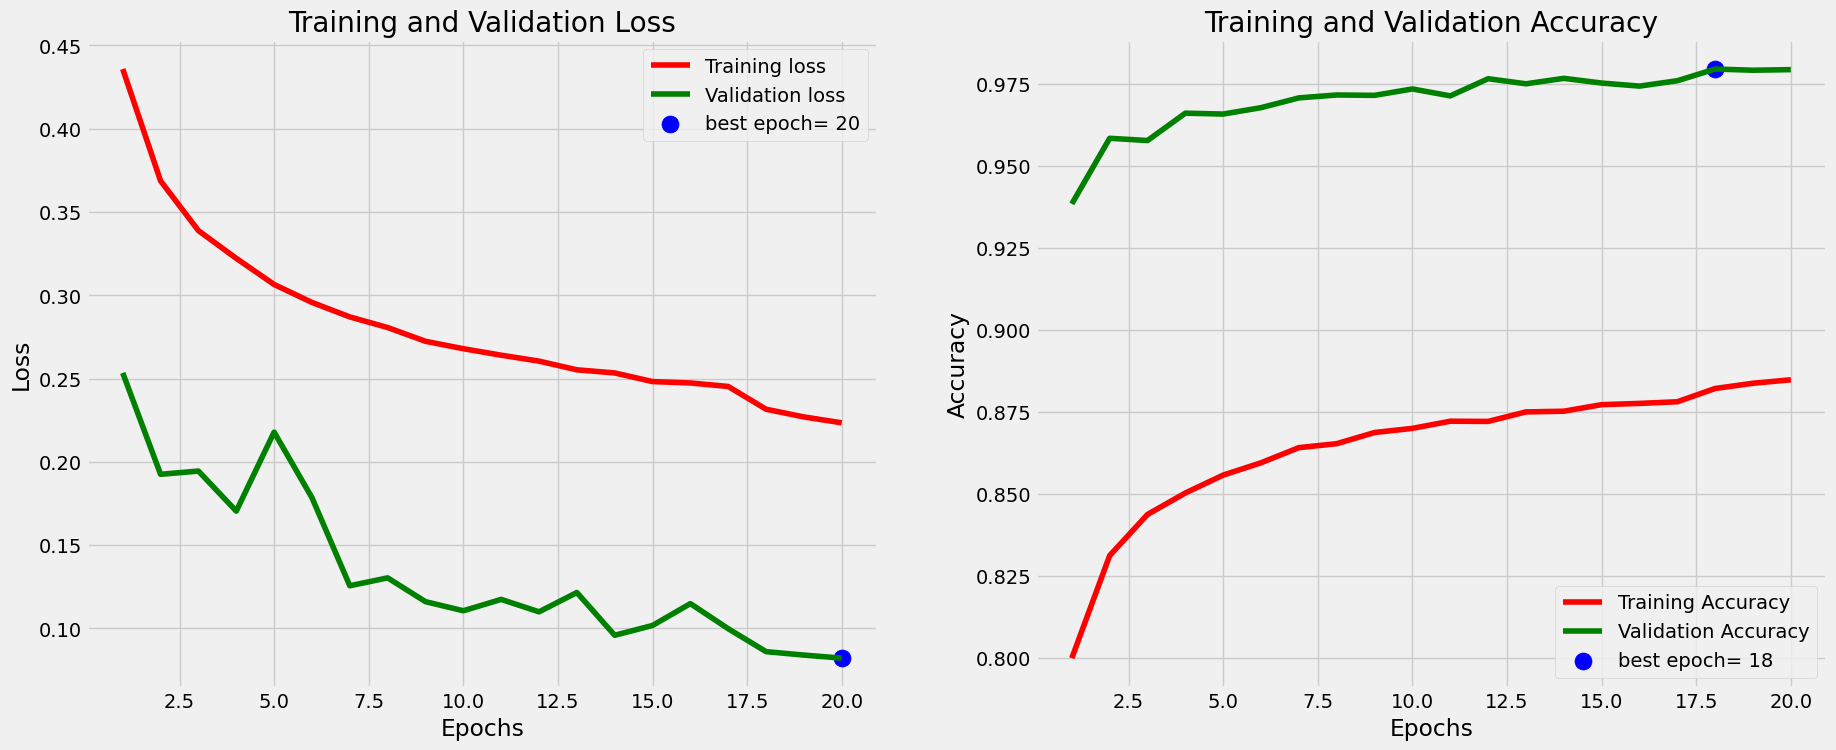

In [41]:
plot_loss_accuracy(history_ensemble_Xception_EfficientNetB7)

From the plot we can see that the loss function and the accuracy are going to the right direction. I belive if we give it more epochs to train, it may do better. So we will try to run it for 20 more epochs.

In [ ]:
model = load_model('model.ensemble_Xception_EfficientNetB7.h5')
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks=get_callbacks('ensemble_Xception_EfficientNetB7')
history_ensemble_Xception_EfficientNetB7=model.fit(train_gen,epochs=20,validation_data=valid_gen,callbacks=[callbacks])

Epoch 1/20
5501/5501 [==============================] - ETA: 0s - loss: 0.2371 - accuracy: 0.8803
Epoch 1: saving model to model.ensemble_Xception_EfficientNetB7.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5501/5501 [==============================] - 1180s 193ms/step - loss: 0.2371 - accuracy: 0.8803 - val_loss: 0.1256 - val_accuracy: 0.9739 - lr: 0.0010
Epoch 2/20
5501/5501 [==============================] - ETA: 0s - loss: 0.2395 - accuracy: 0.8787
Epoch 2: saving model to model.ensemble_Xception_EfficientNetB7.h5
5501/5501 [==============================] - 1062s 193ms/step - loss: 0.2395 - accuracy: 0.8787 - val_loss: 0.1280 - val_accuracy: 0.9761 - lr: 0.0010
Epoch 3/20
5501/5501 [==============================] - ETA: 0s - loss: 0.2356 - accuracy: 0.8810
Epoch 3: saving model to model.ensemble_Xception_EfficientNetB7.h5
5501/5501 [==============================] - 1073s 195ms/step - loss: 0.2356 - accuracy: 0.8810 - val_loss: 0.0898 - val_accuracy: 0.9765 - lr: 0.0010
Epoch 4/20
5501/5501 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.8806
Epoch 4: saving model to model.ensemble_Xception_EfficientNetB7.h5
5501/5501 [==============================] - 1064s 1

# Conclusion

We have seen so far that our best performing models are:

- EfficientNetB7 : 0.8797
- Xception : 0.8763

Ensemble model didn't outperform the two models, probably because the models learn similar pattern and not so much different paterns.